In [2]:
import json, sys, os, glob, re
from os import listdir

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import load_digits
from sklearn.model_selection import learning_curve, ShuffleSplit, train_test_split
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import SelectKBest

from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import make_scorer

import warnings
warnings.filterwarnings("ignore")

In [3]:
%load_ext autoreload
%autoreload 2

sys.path.insert(0, 'src')
from helper import *
from eda import *
from train import *                       
from etl import *

In [4]:
dir_ = 'data/raw/train_c'
the_csv_youre_using = listdir(dir_)[0] # gets first file you have in `data/raw/train_c` directory
print(the_csv_youre_using)

mergedtable = readfilerun_simple(os.path.join(dir_, the_csv_youre_using), dir_) # merges losslog. make sure you have losslog in the same train_c directory
df = genfeat(mergedtable.copy()) # generates all the adjacent features we train on!
df

20220201T010740_200-100-true-200-10000-200-iperf.csv


,Time,IP1,Port1,IP2,Port2,Proto,1->2Bytes,2->1Bytes,1->2Pkts,2->1Pkts,...,total_pkts,pkt sum,longest_seq,mean_tdelta,max_tdelta,number_ms,total_pkt_sizes,pkt_ratio,time_spread,byte_ratio
0,1643677660,192.168.96.3,47330,192.168.48.2,5001,6,13664,60,11,1,...,12,13724,11,0.000000,0,1,13724,1143.666667,0,1143.666667
1,1643677661,192.168.96.3,47330,192.168.48.2,5001,6,51000,1520,34,26,...,60,52520,3,13.694915,402,8,52520,875.333333,808,875.333333
2,1643677662,192.168.96.3,47330,192.168.48.2,5001,6,42000,1456,28,28,...,56,43456,2,7.400000,399,9,43456,776.000000,407,776.000000
4,1643677663,192.168.96.3,47330,192.168.48.2,5001,6,63000,1196,42,23,...,65,64196,3,12.656250,400,11,64196,987.630769,810,987.630769
5,1643677664,192.168.96.3,47330,192.168.48.2,5001,6,42000,728,28,14,...,42,42728,2,9.878049,399,7,42728,1017.333333,405,1017.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
303,1643677957,192.168.96.3,47330,192.168.48.2,5001,6,1807500,24232,1205,466,...,1671,1831732,10,0.583234,33,243,1831732,1096.189108,974,1096.189108
304,1643677958,192.168.96.3,47330,192.168.48.2,5001,6,1576500,21788,1051,419,...,1470,1598288,7,0.675970,36,199,1598288,1087.270748,993,1087.270748
305,1643677959,192.168.96.3,47330,192.168.48.2,5001,6,2160000,29224,1440,562,...,2002,2189224,8,0.493253,34,223,2189224,1093.518482,987,1093.518482
306,1643677960,192.168.96.3,47330,192.168.48.2,5001,6,1881000,26884,1254,517,...,1771,1907884,8,0.554802,35,210,1907884,1077.291925,982,1077.291925


In [5]:
df[['loss', 'latency', 'switch_label']] # labels!

,loss,latency,switch_label
0,100,200,200
1,100,200,200
2,100,200,200
4,100,200,200
5,100,200,200
...,...,...,...
303,10000,200,200
304,10000,200,200
305,10000,200,200
306,10000,200,200


In [6]:
ct = pd.read_csv("outputs/combined_transform.csv")
ct.columns

Index(['total_bytes', 'Proto', '1->2Bytes', '1->2Bytes_var', '2->1Bytes',
       '2->1Bytes_var', '1->2Pkts', '1->2Pkts_var', '2->1Pkts', '2->1Pkts_var',
       'total_pkts', 'total_pkts_amin', 'total_pkts_amax', 'number_ms',
       'number_ms_var', 'pkt_ratio', 'pkt_ratio_var', 'time_spread',
       'time_spread_amin', 'time_spread_amax', 'pkt sum', 'pkt sum_var',
       'longest_seq', 'longest_seq_amin', 'longest_seq_amax',
       'total_pkt_sizes', 'total_pkt_sizes_var', 'byte_ratio',
       'byte_ratio_var', 'mean_tdelta', 'mean_tdelta_amin', 'mean_tdelta_amax',
       'mean_tdelta_var', 'max_tdelta', 'max_tdelta_amin', 'max_tdelta_amax',
       'latency', 'loss', 'later_latency', 'later_loss'],
      dtype='object')

In [7]:
# ct.corr()

<AxesSubplot:>

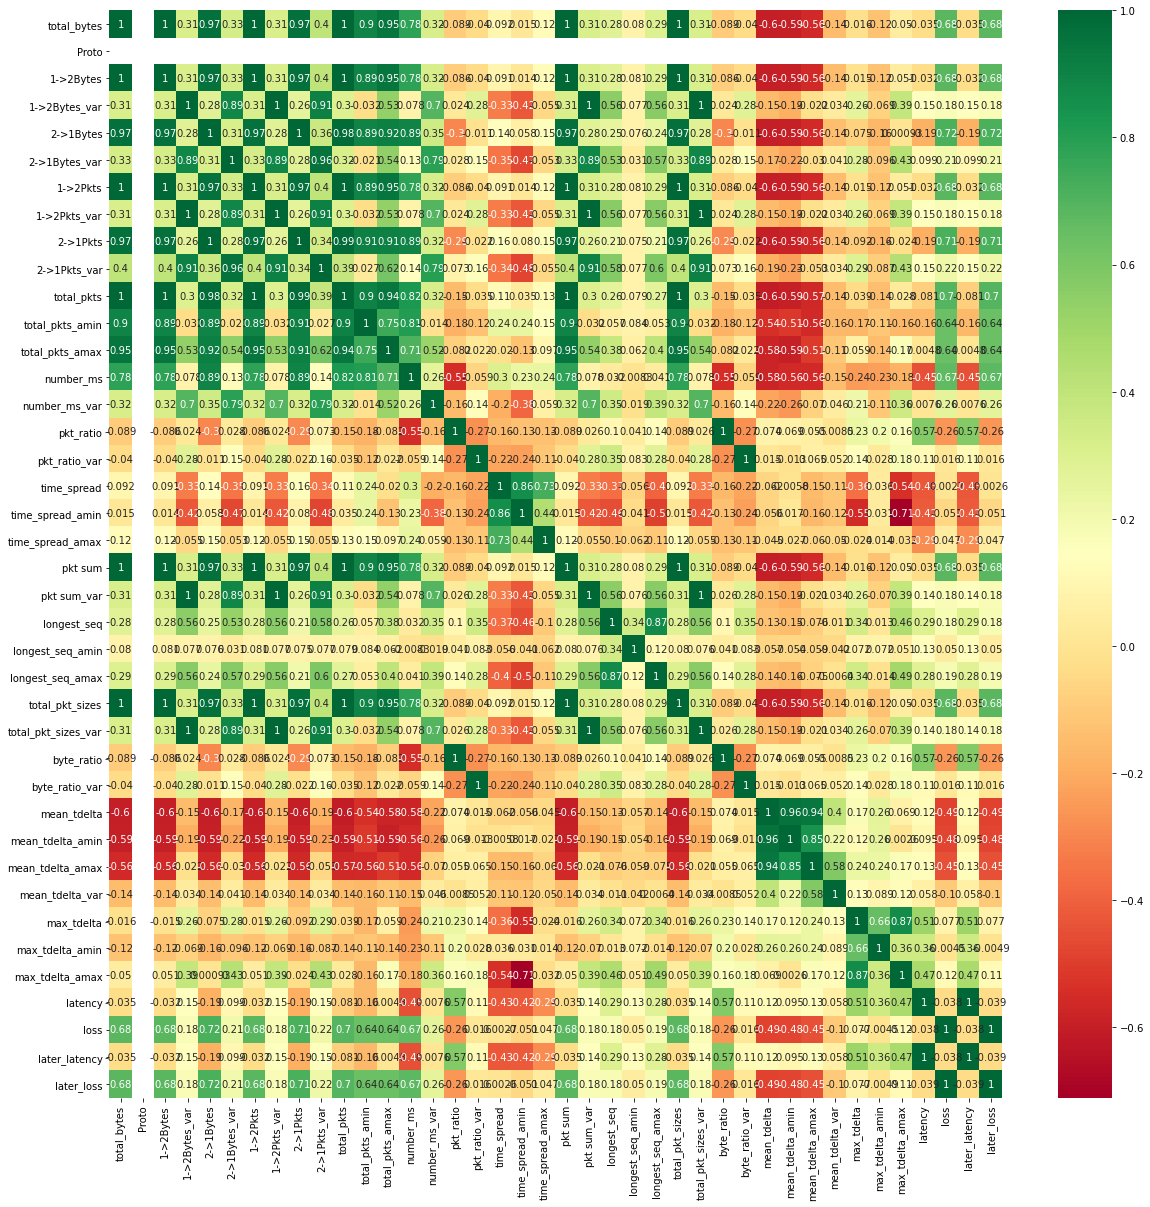

In [8]:
corrmat = ct.corr()
top_corr_features = corrmat.index
fig = plt.figure(figsize=(20,20))
sns.heatmap(ct[top_corr_features].corr(),annot=True,cmap="RdYlGn")

In [9]:
e = feat_impt('latency')
e

mse: 5039.984947262683, r2: 0.7874775062517736


max_tdelta         0.207267
pkt_ratio          0.165748
byte_ratio         0.149328
number_ms          0.133754
time_spread        0.104814
longest_seq        0.038979
mean_tdelta        0.031546
total_pkt_sizes    0.030811
pkt sum            0.030188
total_bytes        0.030089
2->1Pkts           0.026824
total_pkts         0.025461
2->1Bytes          0.025191
dtype: float64

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Fitting 5 folds for each of 5 candidates, totalling 25 fits


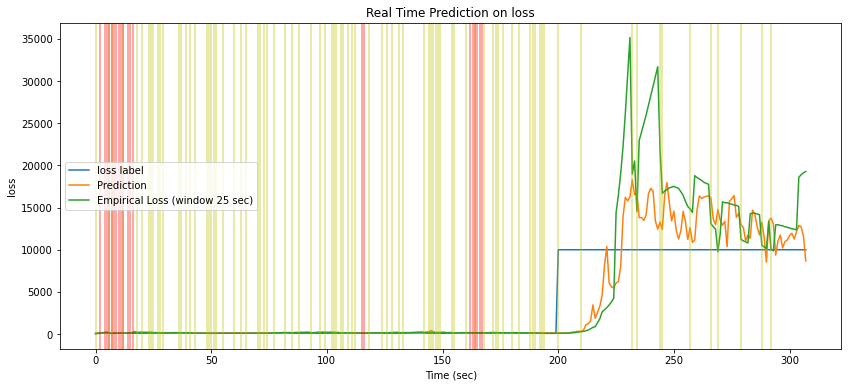

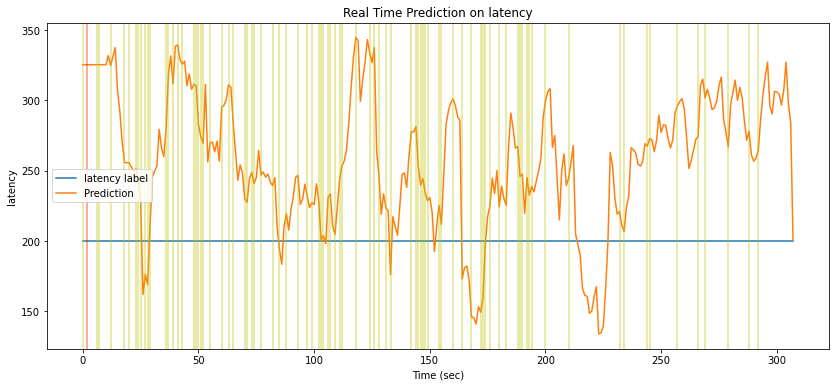

In [13]:
def gen_model(df, label, emplosswindow=25, n_jobs=-1, n_estimators=200):
    """generates predictive model and outputs predictions to new column in input df"""
    if label == "loss":
        # loss features
        indexcol = ["byte_ratio", "pkt_ratio", "time_spread", "total_bytes", "2->1Pkts"]
    elif label == "latency":
        # latency features
        indexcol = [
            "total_pkts",
            "total_pkt_sizes",
            "2->1Bytes",
            "number_ms",
            "mean_tdelta",
            "max_tdelta",
            "time_spread",
            "longest_seq",
        ]

    ## takes transformed datababy from outputs (should be in gdrive)
    ct = pd.read_csv("outputs/combined_transform.csv")

    X_train, X_test, y_train, y_test = train_test_split(
        ct[[x for x in indexcol if x in df.columns]], ct[label]
    )
    # print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
    # mdl = RandomForestRegressor(n_estimators=100, n_jobs=4)
    # mdl = Pipeline(steps=[
    #     ('reduce_dim', PCA(4)), 
    #     ('clf', ExtraTreesRegressor(n_jobs=n_jobs, n_estimators=n_estimators))])

    pipe = Pipeline(steps=[
        ('reduce_dim', PCA()), 
        ('clf', ExtraTreesRegressor(max_depth=7))])
    param_grid = [{'clf' : [ExtraTreesRegressor()],
                   'clf__n_estimators' : list(range(40,170,30))}
    ]
    mdl = GridSearchCV(pipe, param_grid = param_grid, cv = 5, verbose=True, n_jobs=-1)

    mdl = mdl.fit(X_train, y_train)

    df["prediction"] = mdl.predict(
        df[indexcol].rolling(10).mean().bfill()
    )  # prediction on mean aggregation

    def emp_loss(df, window=25):
        """returns empirical loss of a dataframe with the provided data over a specified window of time."""
        return (
            df["total_pkts"].rolling(window, min_periods=1).sum()
            / df["event"]
            .str.replace("switch", "")
            .str.split(";")
            .str.len()
            .fillna(0)
            .rolling(window, min_periods=1)
            .sum()
        )

    ## plotting performance visual
    # fig = plt.figure()
    df[[label, "prediction"]].plot(
        figsize=(14, 6),
        title=f"Real Time Prediction on {label}",
        xlabel="Time (sec)",
        ylabel=label,
    )
    if label == "loss":
        emp_loss(df, emplosswindow).plot()

    if label == "loss":
        plt.legend(
            [
                f"{label} label",
                "Prediction",
                f"Empirical Loss (window {emplosswindow} sec)",
            ],
            loc="center left",
        )
    else:
        plt.legend(
            [
                f"{label} label",
                "Prediction",
            ],
            loc="center left",
        )
    for i in df[~df["event"].isnull()].index:
        plt.axvline(x=i, color="y", alpha=0.45)

    ## adds new column to df
    df[f"pred_{label}"] = mdl.predict(df.rolling(10, min_periods=1)[indexcol].mean())
    
    df[f'pred_{label}_pctc2_smooth'] = df[f'pred_{label}'].rolling(10, min_periods=1).mean().pct_change(2).rolling(10, min_periods=1).mean()
    for i in df[df[f'pred_{label}_pctc2_smooth'] <= -0.1].index: # indices where negative percent change is higher than 0.1
        plt.axvline(x=i, color='r', alpha=.45)
    return mdl


lossmodel = gen_model(df, "loss")
latmodel = gen_model(df, "latency")


In [ ]:
latmodel.best_estimator_

Pipeline(steps=[('reduce_dim', PCA()),
                ('clf', ExtraTreesRegressor(max_depth=7, n_estimators=130))])

In [ ]:
latmodel.best_estimator_

Pipeline(steps=[('reduce_dim', PCA(n_components=4)),
                ('clf', ExtraTreesRegressor(max_depth=7, n_estimators=50))])

In [ ]:
lossmodel.best_estimator_

Pipeline(steps=[('reduce_dim', PCA()),
                ('clf', ExtraTreesRegressor(max_depth=7))])

In [ ]:
lossmodel.best_estimator_

Pipeline(steps=[('reduce_dim', PCA(n_components=4)),
                ('clf', ExtraTreesRegressor(max_depth=7, n_estimators=150))])

In [ ]:
df[['loss', 'latency', 'pred_loss', 'pred_latency']]

,loss,latency,pred_loss,pred_latency
0,100,200,688.0,483.5
1,100,200,100.0,462.5
2,100,200,100.0,394.0
4,100,200,100.0,364.5
5,100,200,100.0,353.0
...,...,...,...,...
303,10000,200,9230.0,273.5
304,10000,200,9510.0,263.0
305,10000,200,10790.0,210.6
306,10000,200,10380.0,198.5


In [ ]:
# trying to smooth our the wigglies we arent interested in
df[['smoothed_pred_loss', 'smoothed_pred_latency']] = df[['pred_loss', 'pred_latency']].rolling(20,min_periods=1).mean()
df[['smoothed_pred_loss', 'smoothed_pred_latency']]

,smoothed_pred_loss,smoothed_pred_latency
0,688.0,483.500000
1,394.0,473.000000
2,296.0,446.666667
4,247.0,426.125000
5,217.6,411.500000
...,...,...
303,9954.5,290.200000
304,9703.0,288.750000
305,9522.5,284.530000
306,9424.0,278.405000


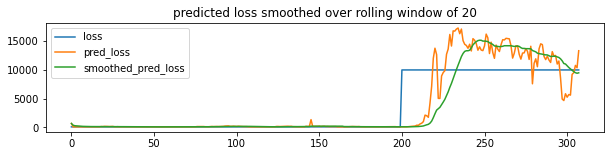

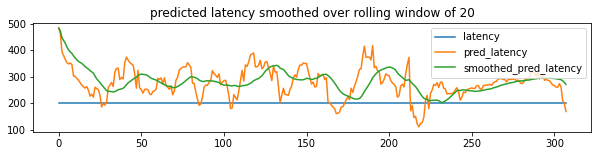

In [ ]:
def plot_different_windowsizes(windowsize=20):
    tempdf = df[['loss', 'pred_loss', 'latency', 'pred_latency']]
    tempdf['smoothed_pred_loss'] = tempdf['pred_loss'].rolling(windowsize,min_periods=1).mean()
    tempdf['smoothed_pred_latency'] = tempdf['pred_latency'].rolling(windowsize,min_periods=1).mean()
    tempdf[['loss', 'pred_loss', 'smoothed_pred_loss']].plot(title=f'predicted loss smoothed over rolling window of {windowsize}', figsize=(10,2))
    tempdf[['latency', 'pred_latency', 'smoothed_pred_latency']].plot(title=f'predicted latency smoothed over rolling window of {windowsize}', figsize=(10,2))
plot_different_windowsizes()

In [ ]:
# for i in range(10, 50, 10):
#     plot_different_windowsizes(i)

<AxesSubplot:title={'center':'loss prediction diffs'}>

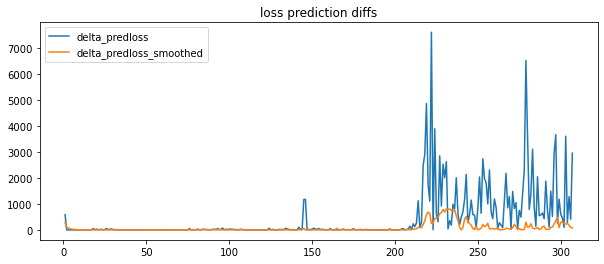

In [ ]:
df[['delta_predloss_smoothed', 'delta_predloss']] = df[['smoothed_pred_loss', 'pred_loss']].diff().abs()
df[['delta_predloss', 'delta_predloss_smoothed']].plot(title='loss prediction diffs', figsize=(10,4))

<AxesSubplot:title={'center':'loss prediction diffs'}>

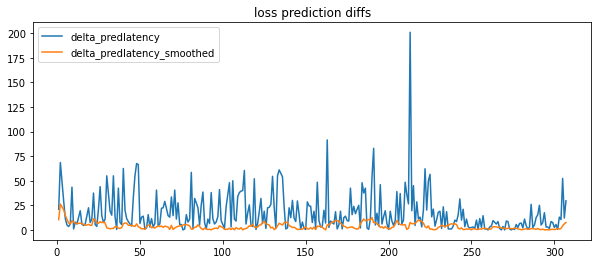

In [ ]:
df[['delta_predlatency_smoothed', 'delta_predlatency']] = df[['smoothed_pred_latency', 'pred_latency']].diff().abs()
df[['delta_predlatency', 'delta_predlatency_smoothed']].plot(title='loss prediction diffs', figsize=(10,4))

yeah, probably a good idea to smooth it out or something.

In [ ]:
# TODO find that threshold for a significant delta in predictions!
# TODO test this on more interesting dane runs! latency was the same in this analysis.
df

,Time,IP1,Port1,IP2,Port2,Proto,1->2Bytes,2->1Bytes,1->2Pkts,2->1Pkts,...,byte_ratio,prediction,pred_loss,pred_latency,smoothed_pred_loss,smoothed_pred_latency,delta_predloss_smoothed,delta_predloss,delta_predlatency_smoothed,delta_predlatency
0,1643677660,192.168.96.3,47330,192.168.48.2,5001,6,13664,60,11,1,...,1143.666667,301.0,688.0,483.5,688.0,483.500000,NaN,NaN,NaN,NaN
1,1643677661,192.168.96.3,47330,192.168.48.2,5001,6,51000,1520,34,26,...,875.333333,301.0,100.0,462.5,394.0,473.000000,294.0,588.0,10.500000,21.0
2,1643677662,192.168.96.3,47330,192.168.48.2,5001,6,42000,1456,28,28,...,776.000000,301.0,100.0,394.0,296.0,446.666667,98.0,0.0,26.333333,68.5
4,1643677663,192.168.96.3,47330,192.168.48.2,5001,6,63000,1196,42,23,...,987.630769,301.0,100.0,364.5,247.0,426.125000,49.0,0.0,20.541667,29.5
5,1643677664,192.168.96.3,47330,192.168.48.2,5001,6,42000,728,28,14,...,1017.333333,301.0,100.0,353.0,217.6,411.500000,29.4,0.0,14.625000,11.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
303,1643677957,192.168.96.3,47330,192.168.48.2,5001,6,1807500,24232,1205,466,...,1096.189108,273.5,9230.0,273.5,9954.5,290.200000,222.0,3610.0,0.900000,13.0
304,1643677958,192.168.96.3,47330,192.168.48.2,5001,6,1576500,21788,1051,419,...,1087.270748,263.0,9510.0,263.0,9703.0,288.750000,251.5,280.0,1.450000,10.5
305,1643677959,192.168.96.3,47330,192.168.48.2,5001,6,2160000,29224,1440,562,...,1093.518482,210.6,10790.0,210.6,9522.5,284.530000,180.5,1280.0,4.220000,52.4
306,1643677960,192.168.96.3,47330,192.168.48.2,5001,6,1881000,26884,1254,517,...,1077.291925,198.5,10380.0,198.5,9424.0,278.405000,98.5,410.0,6.125000,12.1


<AxesSubplot:>

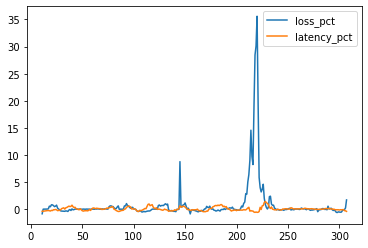

In [ ]:
df[['loss_pct', 'latency_pct']] = df[['pred_loss', 'pred_latency']].pct_change(10)
df[['loss_pct', 'latency_pct']].plot()

<AxesSubplot:title={'center':'predicted latency smoothed over rolling window of 10'}>

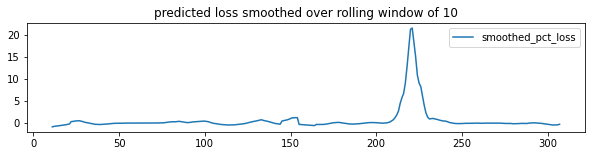

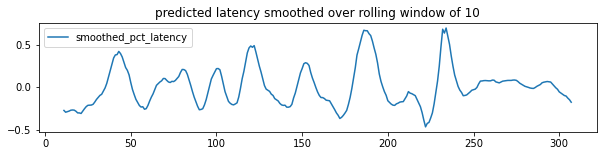

In [ ]:
windowsize = 10
tempdf = df[['loss', 'pred_loss', 'latency', 'pred_latency']]
tempdf['smoothed_pred_loss'] = tempdf['pred_loss'].rolling(windowsize,min_periods=1).mean()
tempdf['smoothed_pred_latency'] = tempdf['pred_latency'].rolling(windowsize,min_periods=1).mean()
tempdf['smoothed_pct_loss'] = tempdf['smoothed_pred_loss'].pct_change(10)
tempdf['smoothed_pct_latency'] = tempdf['smoothed_pred_latency'].pct_change(10)
tempdf[['smoothed_pct_loss']].plot(title=f'predicted loss smoothed over rolling window of {windowsize}', figsize=(10,2))
tempdf[['smoothed_pct_latency']].plot(title=f'predicted latency smoothed over rolling window of {windowsize}', figsize=(10,2))

In [ ]:
df[['delta_predloss_smoothed','delta_predlatency_smoothed']].pct_change()

,delta_predloss_smoothed,delta_predlatency_smoothed
0,NaN,NaN
1,NaN,NaN
2,-0.666667,1.507937
4,-0.500000,-0.219937
5,-0.400000,-0.288032
...,...,...
303,-0.101215,-0.320755
304,0.132883,0.611111
305,-0.282306,1.910345
306,-0.454294,0.451422


Fitting 5 folds for each of 5 candidates, totalling 25 fits
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Fitting 5 folds for each of 5 candidates, totalling 25 fits


,Time,IP1,Port1,IP2,Port2,Proto,1->2Bytes,2->1Bytes,1->2Pkts,2->1Pkts,...,number_ms,total_pkt_sizes,pkt_ratio,time_spread,byte_ratio,prediction,pred_loss,pred_loss_pctc2_smooth,pred_latency,pred_latency_pctc2_smooth
0,1643677660,192.168.96.3,47330,192.168.48.2,5001,6,13664,60,11,1,...,1,13724,1143.666667,0,1143.666667,328.7500,359.3750,NaN,488.1250,NaN
1,1643677661,192.168.96.3,47330,192.168.48.2,5001,6,51000,1520,34,26,...,8,52520,875.333333,808,875.333333,328.7500,148.7500,NaN,424.1875,NaN
2,1643677662,192.168.96.3,47330,192.168.48.2,5001,6,42000,1456,28,28,...,9,43456,776.000000,407,776.000000,328.7500,132.5000,-0.405797,395.6250,-0.106829
4,1643677663,192.168.96.3,47330,192.168.48.2,5001,6,63000,1196,42,23,...,11,64196,987.630769,810,987.630769,328.7500,116.8750,-0.330205,373.4375,-0.092669
5,1643677664,192.168.96.3,47330,192.168.48.2,5001,6,42000,728,28,14,...,7,42728,1017.333333,405,1017.333333,328.7500,118.4375,-0.280006,375.6250,-0.080572
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
303,1643677957,192.168.96.3,47330,192.168.48.2,5001,6,1807500,24232,1205,466,...,243,1831732,1096.189108,974,1096.189108,292.5000,11484.3750,-0.031794,292.5000,0.023510
304,1643677958,192.168.96.3,47330,192.168.48.2,5001,6,1576500,21788,1051,419,...,199,1598288,1087.270748,993,1087.270748,293.4375,12781.2500,-0.027254,293.4375,0.023483
305,1643677959,192.168.96.3,47330,192.168.48.2,5001,6,2160000,29224,1440,562,...,223,2189224,1093.518482,987,1093.518482,293.8750,11706.2500,-0.016990,293.8750,0.019804
306,1643677960,192.168.96.3,47330,192.168.48.2,5001,6,1881000,26884,1254,517,...,210,1907884,1077.291925,982,1077.291925,278.1250,10800.0000,-0.016598,278.1250,0.014683


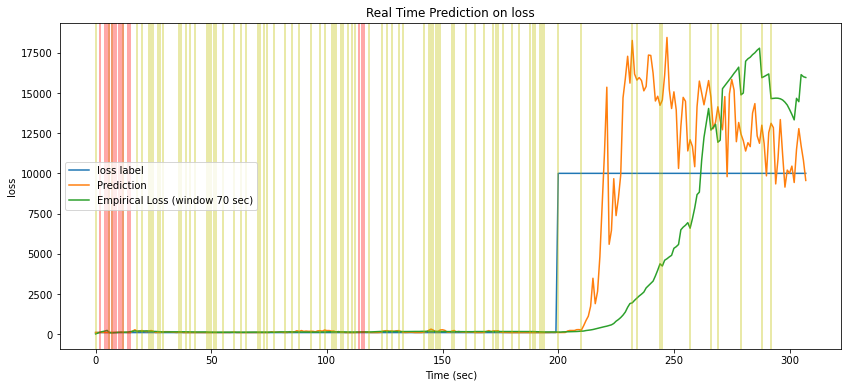

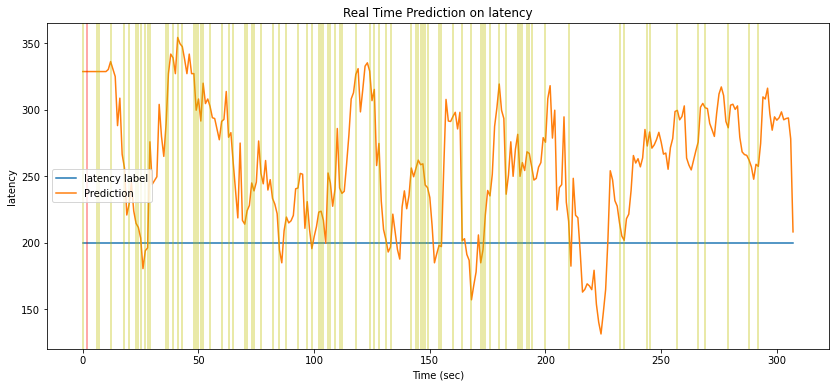

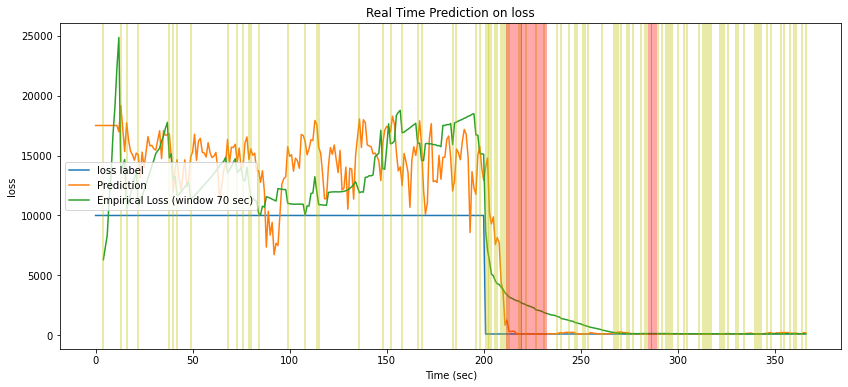

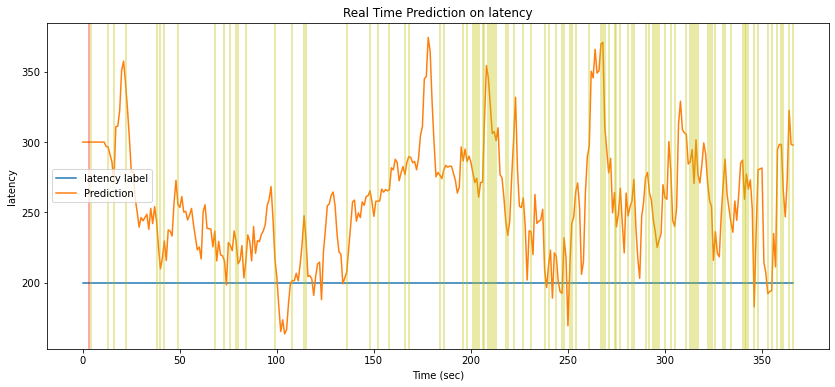

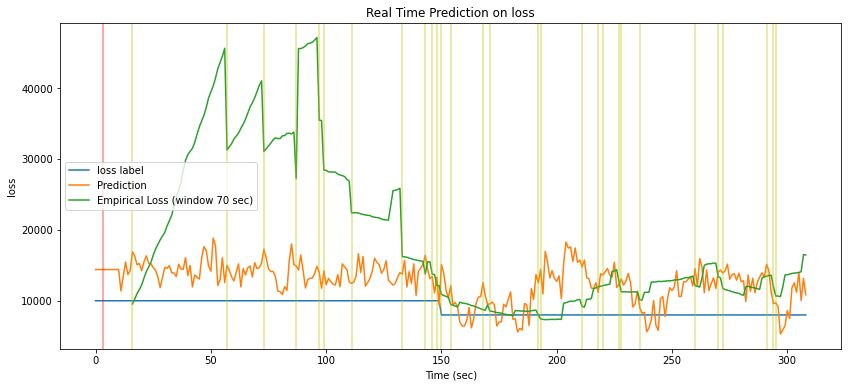

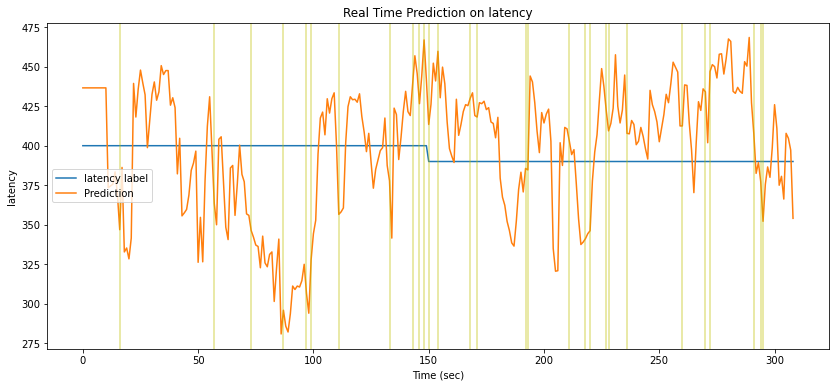

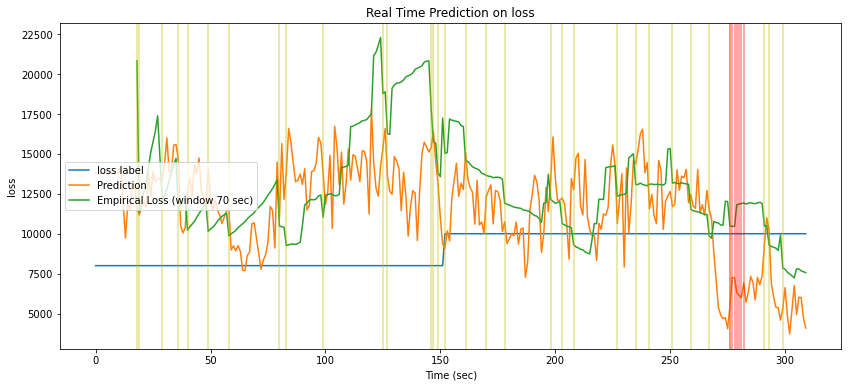

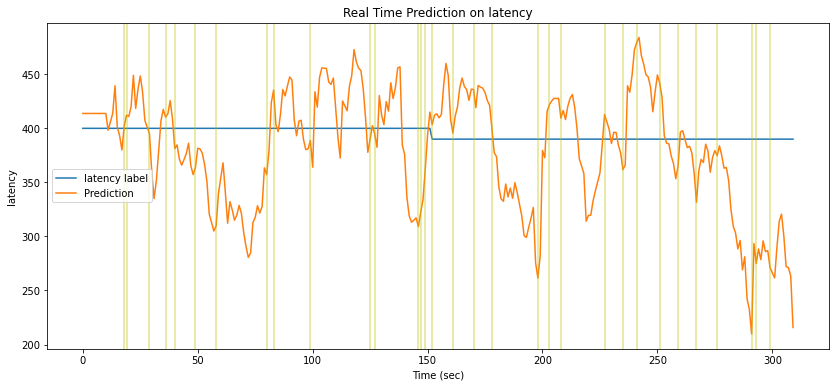

In [14]:
dir_ = 'data/jennawk5data'
lst = []
for i in [x for x in listdir(dir_) if not 'losslog' in x]:
    # the_csv_youre_using = listdir(dir_)

    mergedtable = readfilerun_simple(os.path.join(dir_, i), dir_) # merges losslog. make sure you have losslog in the same train_c directory
    df_ = genfeat(mergedtable) # generates all the adjacent features we train on!
    gen_model(df_, 'loss', 70)
    gen_model(df_, 'latency', 70)
    lst.append(df_)
lst[0]

In [ ]:
lst[0]

,Time,IP1,Port1,IP2,Port2,Proto,1->2Bytes,2->1Bytes,1->2Pkts,2->1Pkts,...,mean_tdelta,max_tdelta,number_ms,total_pkt_sizes,pkt_ratio,time_spread,byte_ratio,prediction,pred_loss,pred_latency
0,1643677660,192.168.96.3,47330,192.168.48.2,5001,6,13664,60,11,1,...,0.000000,0,1,13724,1143.666667,0,1143.666667,281.0,1072.0,494.0
1,1643677661,192.168.96.3,47330,192.168.48.2,5001,6,51000,1520,34,26,...,13.694915,402,8,52520,875.333333,808,875.333333,281.0,106.0,454.0
2,1643677662,192.168.96.3,47330,192.168.48.2,5001,6,42000,1456,28,28,...,7.400000,399,9,43456,776.000000,407,776.000000,281.0,189.0,398.5
4,1643677663,192.168.96.3,47330,192.168.48.2,5001,6,63000,1196,42,23,...,12.656250,400,11,64196,987.630769,810,987.630769,281.0,190.5,388.0
5,1643677664,192.168.96.3,47330,192.168.48.2,5001,6,42000,728,28,14,...,9.878049,399,7,42728,1017.333333,405,1017.333333,281.0,219.0,343.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
303,1643677957,192.168.96.3,47330,192.168.48.2,5001,6,1807500,24232,1205,466,...,0.583234,33,243,1831732,1096.189108,974,1096.189108,275.5,10840.0,275.5
304,1643677958,192.168.96.3,47330,192.168.48.2,5001,6,1576500,21788,1051,419,...,0.675970,36,199,1598288,1087.270748,993,1087.270748,253.4,11530.0,253.4
305,1643677959,192.168.96.3,47330,192.168.48.2,5001,6,2160000,29224,1440,562,...,0.493253,34,223,2189224,1093.518482,987,1093.518482,188.7,11185.0,188.7
306,1643677960,192.168.96.3,47330,192.168.48.2,5001,6,1881000,26884,1254,517,...,0.554802,35,210,1907884,1077.291925,982,1077.291925,183.9,11350.0,183.9


In [ ]:
# loss from 10000 to 100
loss10000to100 = lst[1]

<AxesSubplot:>

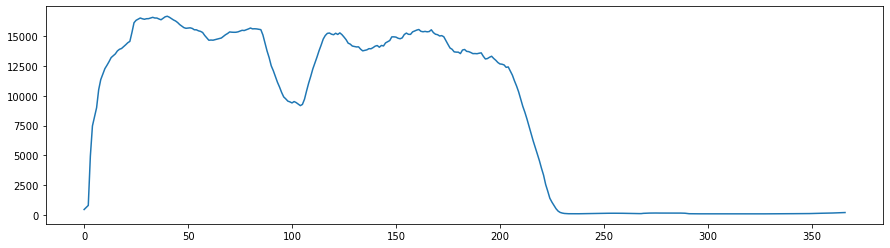

In [ ]:
loss10000to100['pred_loss'].rolling(20, min_periods=1).mean().plot(figsize=(15,4))

<AxesSubplot:>

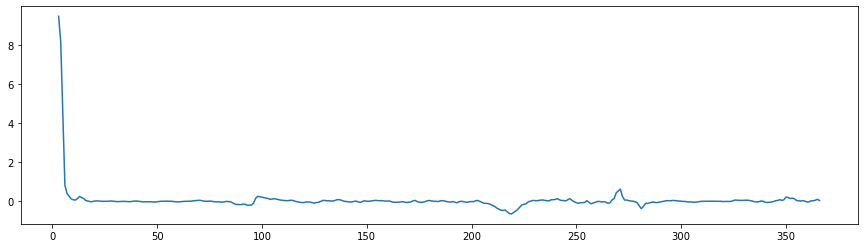

In [ ]:
blah = lst[1]['pred_loss'].rolling(10, min_periods=1).mean().pct_change(2) #.plot(figsize=(15,4))
blah.plot(figsize=(15,4))

<AxesSubplot:>

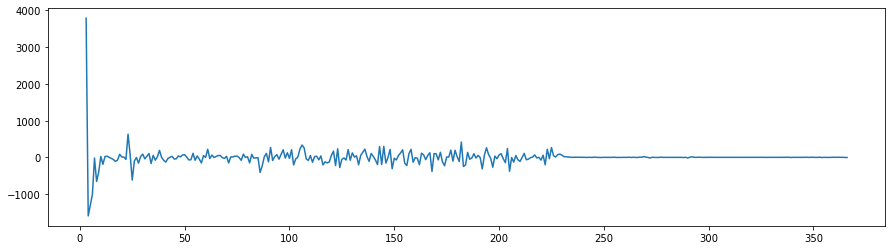

In [ ]:
blah = lst[1]['pred_loss'].rolling(20, min_periods=1).mean().diff().diff()#.plot(figsize=(15,4))
blah.plot(figsize=(15,4))

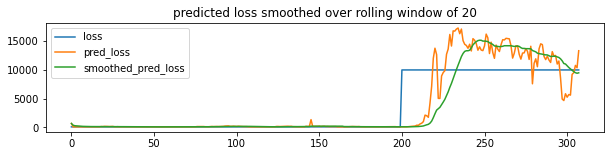

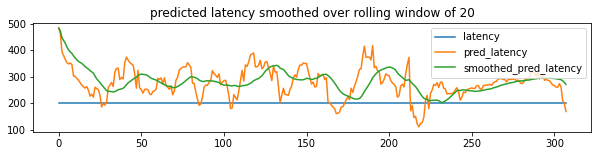

In [ ]:
def plot_different_windowsizes(windowsize=20):
    tempdf = df[['loss', 'pred_loss', 'latency', 'pred_latency']]
    tempdf['smoothed_pred_loss'] = tempdf['pred_loss'].rolling(windowsize,min_periods=1).mean()
    tempdf['smoothed_pred_latency'] = tempdf['pred_latency'].rolling(windowsize,min_periods=1).mean()
    tempdf[['loss', 'pred_loss', 'smoothed_pred_loss']].plot(title=f'predicted loss smoothed over rolling window of {windowsize}', figsize=(10,2))
    tempdf[['latency', 'pred_latency', 'smoothed_pred_latency']].plot(title=f'predicted latency smoothed over rolling window of {windowsize}', figsize=(10,2))
plot_different_windowsizes()

In [ ]:
loss10000to100['pctc2'] = loss10000to100['pred_loss'].rolling(10, min_periods=1).mean().pct_change(2)
loss10000to100['pctc2_smooth'] = loss10000to100['pred_loss'].pct_change(2)
loss10000to100['pctc2']

0           NaN
2           NaN
3      9.476140
4      8.176696
6      0.821581
         ...   
362    0.028030
363    0.029637
364    0.056207
365    0.102902
366    0.045516
Name: pctc2, Length: 360, dtype: float64

In [ ]:
loss10000to100['pctc2'] <= 0.2

0      False
2      False
3      False
4      False
6      False
       ...  
362     True
363     True
364     True
365     True
366     True
Name: pctc2, Length: 360, dtype: bool

In [ ]:
loss10000to100['loss']

0      10000
2      10000
3      10000
4      10000
6      10000
       ...  
362      100
363      100
364      100
365      100
366      100
Name: loss, Length: 360, dtype: int64

not looking for bad traffic
but traffic that is getting worse

In [ ]:
loss10000to100[loss10000to100['pctc2'] <= -0.2].index

Int64Index([ 93, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221,
            222, 223, 280, 281, 282],
           dtype='int64')

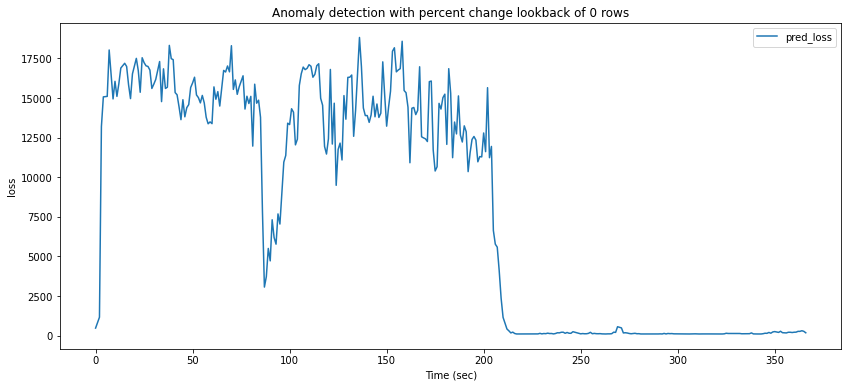

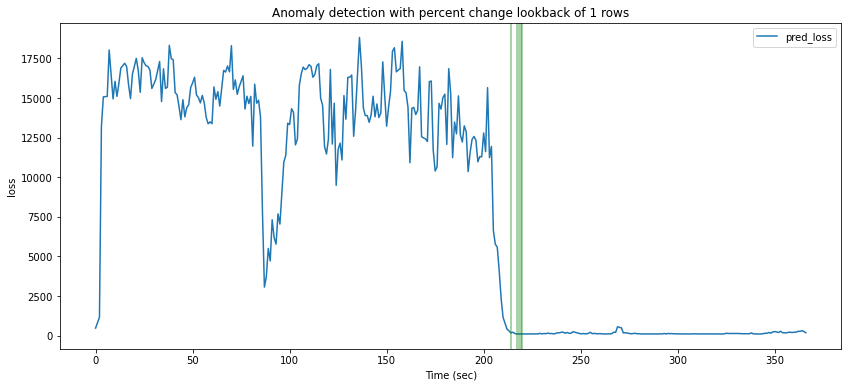

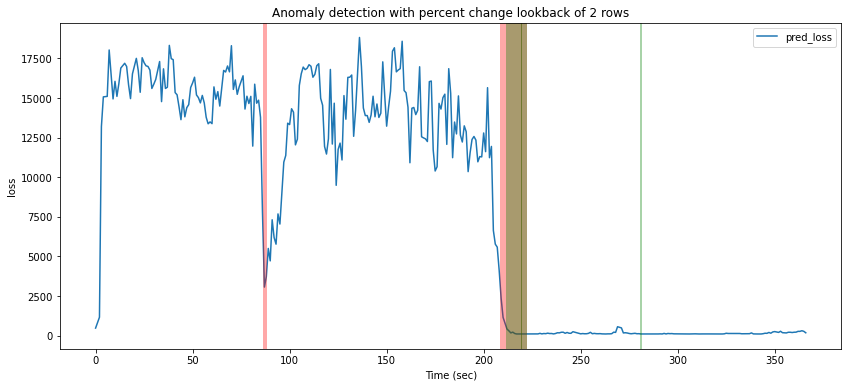

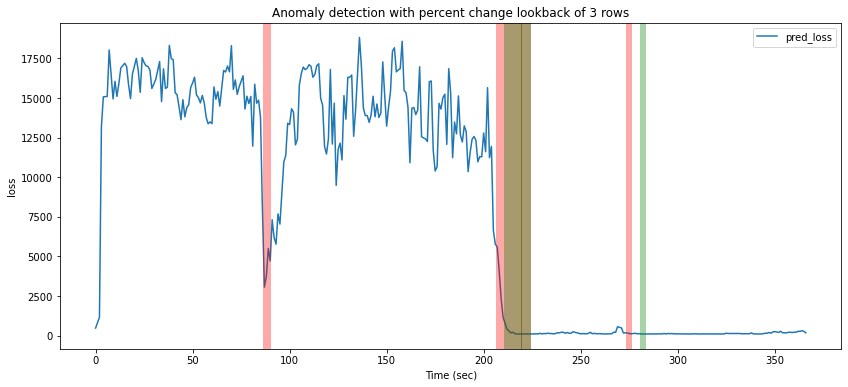

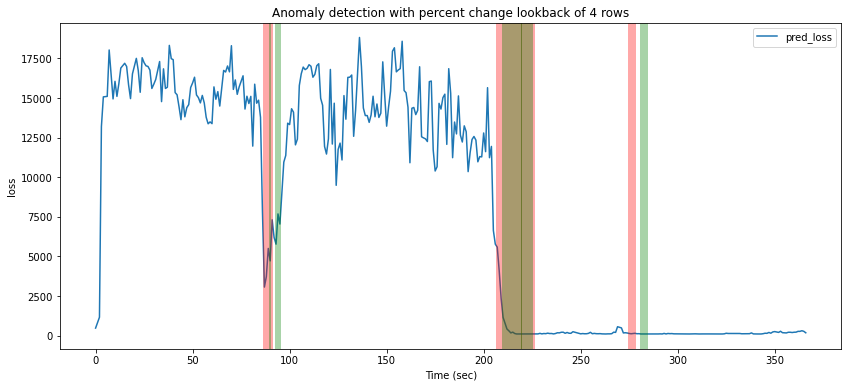

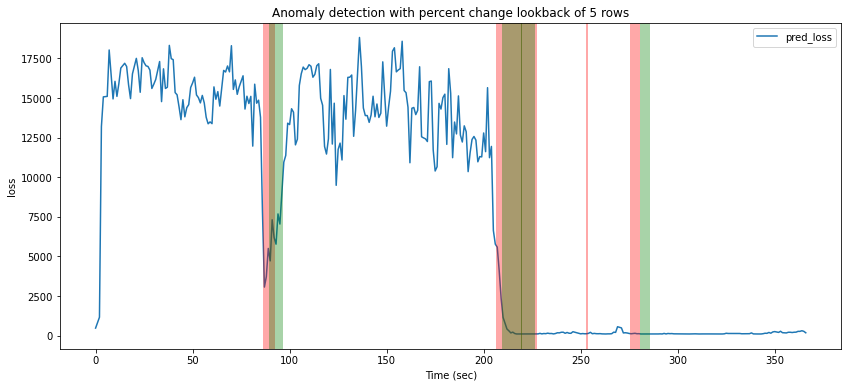

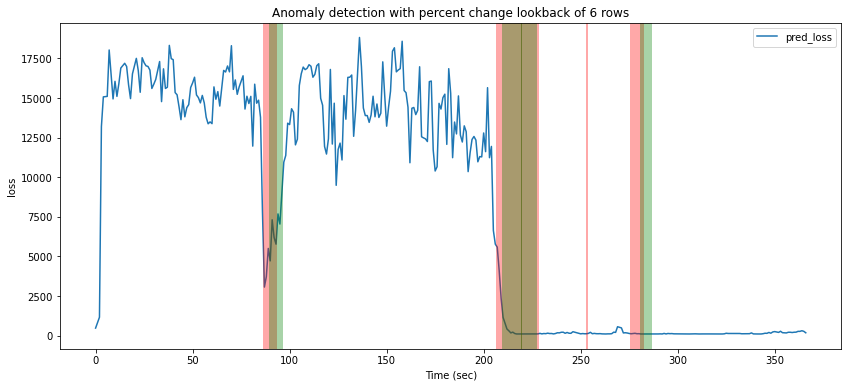

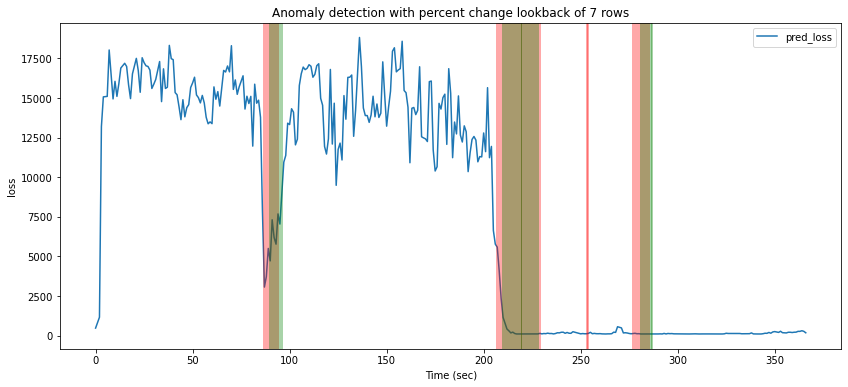

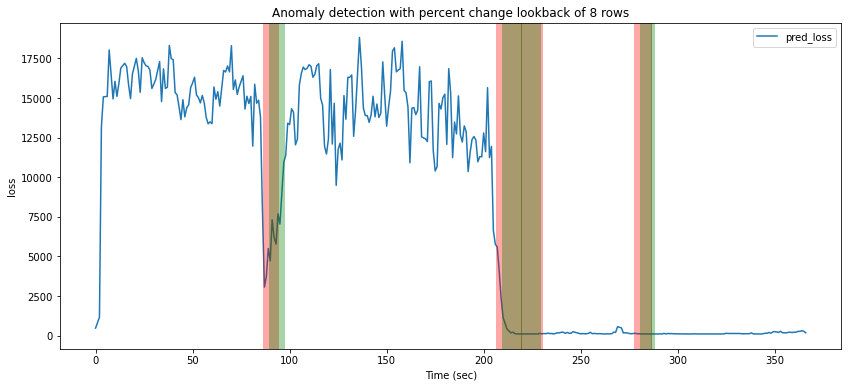

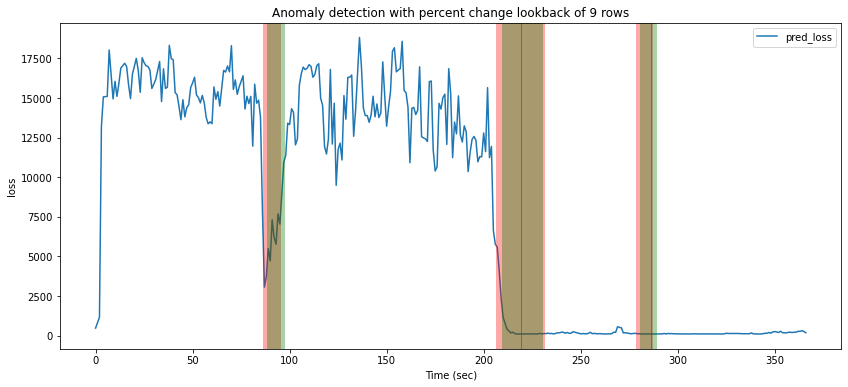

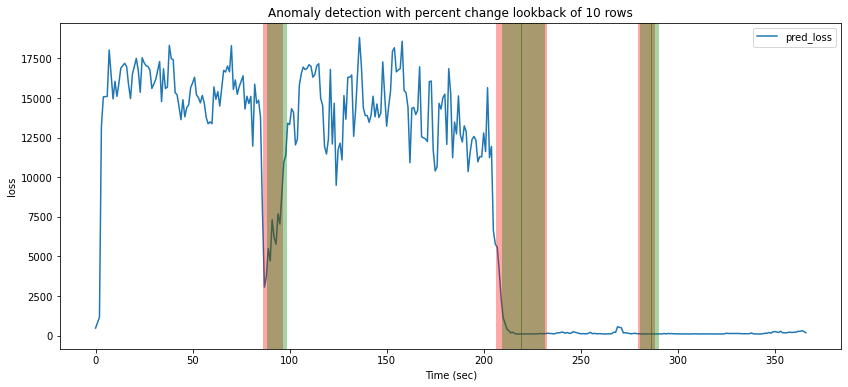

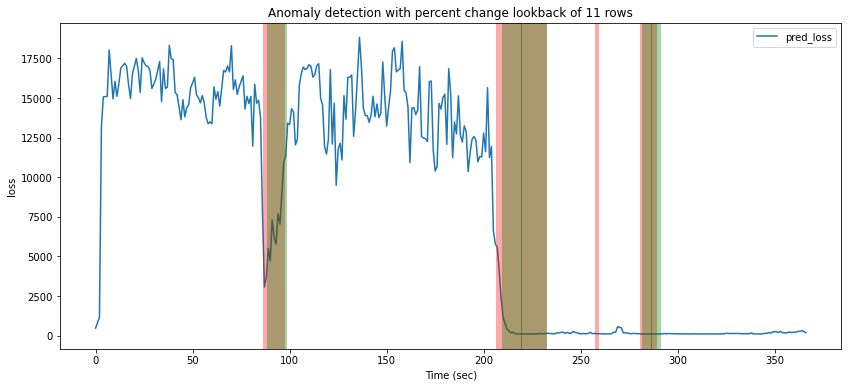

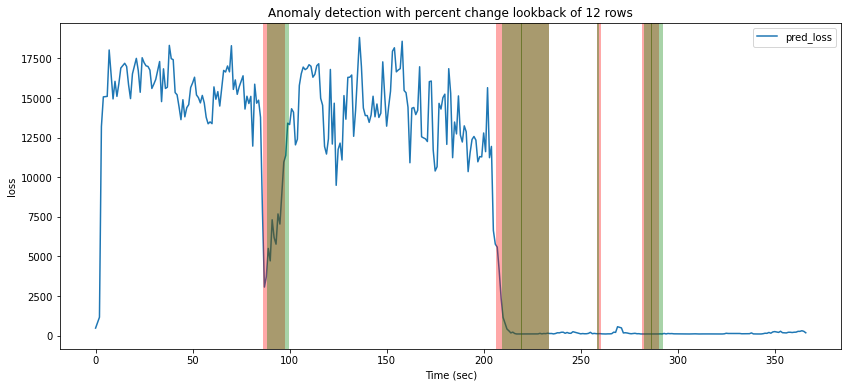

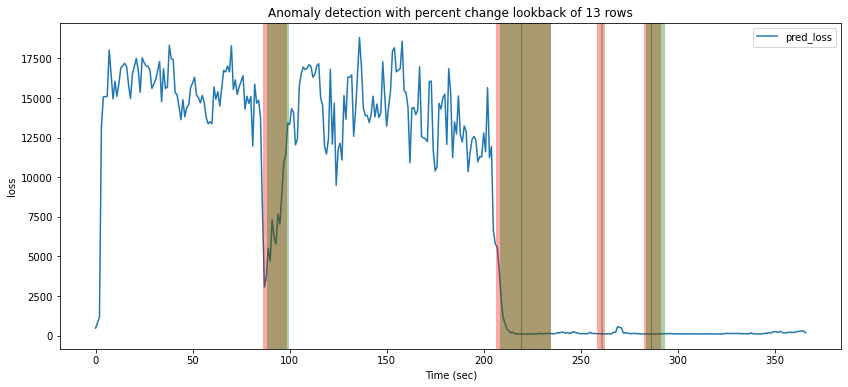

In [ ]:

for pc in range(14):
    loss10000to100['pctc2'] = loss10000to100['pred_loss'].pct_change(pc)
    loss10000to100['pctc2_smooth'] = loss10000to100['pred_loss'].rolling(10, min_periods=1).mean().pct_change(pc)
    loss10000to100['pctc2_expsmooth'] = loss10000to100['pred_loss'].ewm(alpha=0.3, min_periods=1).mean().pct_change(pc)

    plt.figure(figsize=(14,6))
    loss10000to100['pred_loss'].plot(title=f'Anomaly detection with percent change lookback of {pc} rows', 
            xlabel='Time (sec)', ylabel='loss')
    plt.legend()
    for i in loss10000to100[loss10000to100['pctc2_expsmooth'] <= -0.3].index: # indices where negative percent change is higher than 0.3
        plt.axvline(x=i, color='r', alpha=.45)
    for i in loss10000to100[loss10000to100['pctc2_smooth'] <= -0.3].index: # indices where negative percent change is higher than 0.3
        plt.axvline(x=i, color='g', alpha=.45)

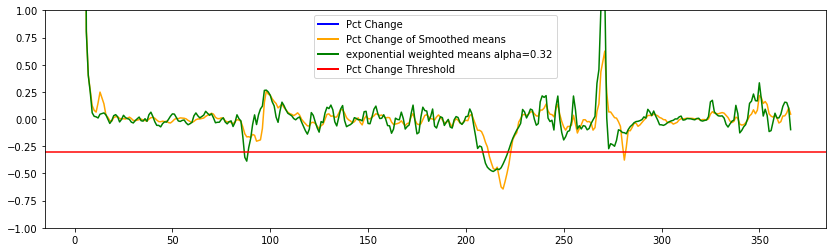

In [ ]:
from matplotlib.lines import Line2D

alpha=0.32

plt.figure(figsize=(14,4))
plt.ylim((-1, 1))
# loss10000to100['pred_loss'].pct_change(2).plot(title='actual percent change', color='blue') # actual
loss10000to100['pred_loss'].rolling(10, min_periods=1).mean().pct_change(2).plot(color='orange') # rolling mean 
loss10000to100['pred_loss'].ewm(alpha=alpha, min_periods=1).mean().pct_change(2).plot(color='green') # exp rolling mean
plt.axhline(-0.3, color='r')
custom_lines = [Line2D([0], [0], color='blue', lw=2), 
                Line2D([0], [0], color='orange', lw=2), 
                Line2D([0], [0], color='green', lw=2), 
                Line2D([0], [0], color='red', lw=2)]
plt.legend(custom_lines, ['Pct Change', 'Pct Change of Smoothed means', f'exponential weighted means alpha={alpha}', 'Pct Change Threshold'])
# for i in loss10000to100[loss10000to100['pctc2'] <= -0.3].index: # indices where negative percent change is higher than 0.3
#     plt.axvline(x=i, color='r', alpha=.45)

In [ ]:
plt

<module 'matplotlib.pyplot' from 'C:\\Users\\Staro\\.conda\\envs\\sklearn\\lib\\site-packages\\matplotlib\\pyplot.py'>

<AxesSubplot:>

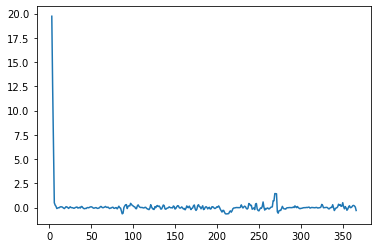

In [ ]:
loss10000to100['pred_loss'].ewm(alpha=0.7, min_periods=1).mean().pct_change(2).plot()

<AxesSubplot:>

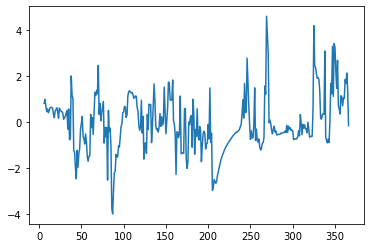

In [ ]:
loss10000to100['pred_loss'].rolling(30, min_periods=5).apply(lambda x: (x.tail(1) - x.mean())/x.std()).plot()

In [ ]:
loss10000to100['packet_dirs']

0      [2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, ...
2      [2, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 2, 1, 1, 2, ...
3      [2, 1, 1, 2, 1, 1, 2, 1, 1, 2, 1, 1, 2, 1, 1, ...
4      [2, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 2, 2, 1, 1, ...
6      [2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, ...
                             ...                        
362    [2, 1, 2, 1, 1, 2, 1, 1, 2, 1, 1, 2, 1, 2, 2, ...
363    [2, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 2, 1, 2, 1, ...
364    [2, 1, 1, 2, 1, 1, 2, 1, 1, 2, 1, 1, 2, 1, 1, ...
365    [2, 1, 2, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, ...
366    [2, 1, 1, 2, 1, 1, 2, 1, 1, 2, 1, 1, 2, 1, 1, ...
Name: packet_dirs, Length: 360, dtype: object

In [ ]:
loss10000to100['packet_times']

0      [1643677661114, 1643677661114, 1643677661115, ...
2      [1643677662324, 1643677662324, 1643677662324, ...
3      [1643677663134, 1643677663134, 1643677663134, ...
4      [1643677664000, 1643677664000, 1643677664000, ...
6      [1643677665183, 1643677665183, 1643677665183, ...
                             ...                        
362    [1643678016046, 1643678016046, 1643678016085, ...
363    [1643678017029, 1643678017029, 1643678017029, ...
364    [1643678018065, 1643678018065, 1643678018065, ...
365    [1643678019051, 1643678019051, 1643678019051, ...
366    [1643678020036, 1643678020036, 1643678020036, ...
Name: packet_times, Length: 360, dtype: object

In [ ]:
mergedtable['packet_dirs']

0                   [2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
1      [2, 1, 1, 2, 1, 1, 2, 1, 1, 2, 1, 1, 2, 1, 1, ...
2      [2, 1, 1, 2, 1, 1, 2, 1, 1, 2, 1, 1, 2, 1, 1, ...
4      [2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 2, 1, ...
5      [2, 1, 1, 2, 1, 1, 2, 1, 1, 2, 1, 1, 2, 1, 1, ...
                             ...                        
305    [2, 1, 1, 2, 1, 2, 1, 1, 2, 1, 1, 2, 1, 1, 2, ...
306    [2, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 2, ...
307    [2, 1, 1, 2, 1, 1, 2, 1, 1, 2, 1, 1, 2, 1, 1, ...
308    [2, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 2, 1, 1, 2, ...
309    [2, 1, 1, 2, 1, 1, 2, 1, 1, 2, 1, 1, 2, 1, 1, ...
Name: packet_dirs, Length: 304, dtype: object

In [ ]:
value=2
mergedtable[f'{value}_idx'] = mergedtable['packet_dirs'].str.replace(';', '').apply(lambda x: [i for i, j in enumerate(x) if j == str(value)])
# mergedtable['packet_dirs'].str.replace('2;', '0').str.replace('1;', '1').apply(lambda x: [i for i, j in enumerate(x) if j == "0"])

TypeError: 'float' object is not iterable

In [ ]:
def mean_diff_dir(lst):
    '''
    returns mean difference in a column, 
    meant to be used on transformed 'packet_times' column
    >>> df['packet_times'].str.split(';').apply(mean_diff)
    '''
    # lst = np.array(list(filter(None, lst))) # takes out empty strings
    temp = np.array(list(map(int, lst)))
    # print(temp)
    mn = np.mean(np.diff(temp))
    return 0 if np.isnan(mn) else mn

In [ ]:
output = mergedtable.apply(lambda x: [h for g, h in enumerate(x['packet_times'].split(';')) if g in [i for i, j in enumerate(x['packet_dirs'].replace(';','')) if j == str(1)]], axis=1).apply(mean_diff_dir)#.plot()
output2 = mergedtable.apply(lambda x: [h for g, h in enumerate(x['packet_times'].split(';')) if g in [i for i, j in enumerate(x['packet_dirs'].replace(';','')) if j == str(2)]], axis=1).apply(mean_diff_dir)#.plot()
output

0       0.000000
1      24.484848
2      15.074074
4      19.756098
5      15.000000
         ...    
303     0.808970
304     0.945714
305     0.685893
306     0.783719
307     0.620584
Length: 302, dtype: float64

In [ ]:
mergedtable.columns

Index(['Time', 'IP1', 'Port1', 'IP2', 'Port2', 'Proto', '1->2Bytes',
       '2->1Bytes', '1->2Pkts', '2->1Pkts', 'packet_times', 'packet_sizes',
       'packet_dirs', 'event', 'drop_unix', 'latency', 'loss', 'later_latency',
       'later_loss', 'deterministic', 'switch_label'],
      dtype='object')

In [ ]:
df.columns

Index(['Time', 'IP1', 'Port1', 'IP2', 'Port2', 'Proto', '1->2Bytes',
       '2->1Bytes', '1->2Pkts', '2->1Pkts', 'packet_times', 'packet_sizes',
       'packet_dirs', 'event', 'drop_unix', 'latency', 'loss', 'later_latency',
       'later_loss', 'deterministic', 'switch_label', 'total_bytes',
       'total_pkts', 'pkt sum', 'longest_seq', 'mean_tdelta', 'max_tdelta',
       'number_ms', 'total_pkt_sizes', 'pkt_ratio', 'time_spread',
       'byte_ratio'],
      dtype='object')

<AxesSubplot:>

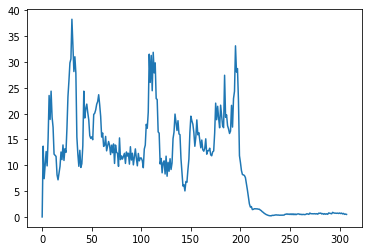

In [ ]:
df['mean_tdelta'].plot()

In [ ]:
output.plot()

[]

In [ ]:
output2.plot()

[]